# Perturbation Mean Squared Error (P-MSE)

### Given one or more points, a model and a function of interest, this script computes:
### (i) SmoothHess, SmoothGrad, SoftPluss Hess, SoftPlus Grad and Vanilla Grad 
### (ii) P-MSE of each method for the points

### The Script As Is Below Runs in <7 mins on an NVIDIA V100 32GB

In [12]:
import pandas as pd
import numpy as np
import torch 
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Local Imports 
from Datasets import * 
from Models import * 
from ComputeDerivatives import Generate_Grad_Hess_From_List
from Evaluation import Compute_PMSE

# For User To Choose:
### Dataset, Function of Interest, Number of points to evaluate, Radius, Sigma and Beta 

In [13]:
dataset = "MNIST" # Choose Dataset From: { MNIST, FMNIST or CIFAR10 }
function = "Logit" # Choose Function Of Interest From: { Logit, SoftMax, Penult_X} where X is the desired integer index of any penultimate neuron 
ind = 0  # Starting index for eval
hop = 15 # Number of points to eval i.e. ind = 1 hop = 10 --> points used index: 10, 11, 12, ..., 19 
rs = [0.5]  ####### Radius of interest for P-MSE , include in list format 

##### Smoothing Method Hyperparameters ############
sigma = 1.8e-4 # SmoothHess SmoothGrad Hyperparamter  --- 1.8e-4 is best found value for MNIST Logit for SmoothGrad and SmoothHess + SmoothGrad
beta = 180     # SoftPlus Hyperparameter ----- 200 is best found value for MNIST Logit for SoftPlus Grad and SoftPlus Hess + SoftPlus Grad 
##########################################

## Config
### Includes Reccomended configs for each dataset

In [14]:
# Reccomended Loadouts for Each Dataset
if dataset == "MNIST":
    args = {
        "function_use" : function, 
        "iterations" : 30,
        "n1" : 20000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000, 
        "valstart" : 50000,
        "OriginalDim" : (784,)
    }

    # Used to construct network 
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    PMSE_N1, PMSE_N2 = 15000, 1 

elif dataset == "FMNIST":
    args = {
        "function_use" : function, 
        "iterations" : 30,
        "n1" : 20000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 50000,
        "OriginalDim" : (784,)
    }
     
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    PMSE_N1, PMSE_N2 = 15000, 1 

     
elif dataset == "CIFAR10":
    args = {
        "function_use" : function, 
        "iterations" : 120,
        "n1" : 2000, 
        "ConvNet" : 1, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 40000,
        "OriginalDim" : (3,32,32)
    }

    network_args = {
        "pretrained" : 0 ,
        "resnet" : "resnet18",
        "cifarstyle" : 1, 
        "num_classes" : 10,
        'network': "ResNet"
    }
    
    PMSE_N1, PMSE_N2 = 3000, 5 

assert dataset in ["MNIST", "FMNIST", "CIFAR10"]; 
args['binary'] = False 
args['ind'] = ind
args['hop'] = hop
args['sigma'] = sigma
args['beta'] = beta 
args['rs'] = rs 
args['savedir'] = "./ExplainerResults/"

## Load Data and Model

In [15]:
# Load Data 
train_loader, train_data, val_loader, val_data, test_loader, test_data, train_no_shuffle_no_aug_data, train_no_shuffle_no_aug_loader = getattr(sys.modules[__name__], args['dataset'])(**args)
data, _ = next(iter(test_loader))
if dataset in ["MNIST", 'FMNIST']: # Flatten FCN datasets 
    data = data.view(len(data), -1)
data_use = data[ind * hop  : (ind + 1 ) * hop,:]

# Load Model
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

# Estimate SmoothHess and SmoothGrad

In [16]:
SmoothGrad_List, SmoothHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Smooth")

Computing for point 0



Computing for point 5



Computing for point 10


## Estimate P-MSE for SmoothHess and SmoothGrad

In [17]:
Smooth_Hess_Grad_PMSE =  Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, SmoothGrad_List, SmoothHess_List)
SmoothGrad_PMSE = Smooth_Hess_Grad_PMSE[rs[0]].FirstOrder.mean()
SmoothHess_PMSE = Smooth_Hess_Grad_PMSE[rs[0]].SecondOrder.mean()

Computing P-MSE
0


5
10


# Estimate SoftPlus Hessiand and SoftPlus Gradient

In [18]:
SoftPlusGrad_List, SoftPlusHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "SoftPlus")

# Re Load model after potential modifications 
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

Computing for point 0
Computing for point 5
Computing for point 10


# Estimate P-MSE for SoftPlus Hessian and SoftPlus Gradient

In [19]:
SoftPlus_Hess_Grad_PMSE = Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, SoftPlusGrad_List, SoftPlusHess_List)
SoftPlus_Grad_PMSE = SoftPlus_Hess_Grad_PMSE[rs[0]].FirstOrder.mean()
SoftPlus_Hess_PMSE = SoftPlus_Hess_Grad_PMSE[rs[0]].SecondOrder.mean()

Computing P-MSE
0


5
10


# Estimate Vanilla Gradient

In [20]:
VanillaGrad_List, VanillaHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Vanilla") # VanillaHess_List is a formality, it is 0 for ReLU networks interior and output neurons 

Computing for point 0
Computing for point 5
Computing for point 10


# Estimate P-MSE for Vanilla Gradient

In [21]:
Vanilla_Grad_PMSE = Compute_PMSE(model, PMSE_N1, PMSE_N2, data_use, args['OriginalDim'], function, rs, VanillaGrad_List, VanillaHess_List)
VanillaGrad_PMSE = Vanilla_Grad_PMSE[rs[0]].FirstOrder.mean()

Computing P-MSE
0


5
10


# Plot P-MSE For Each Method

Text(0.5, 0, 'Method')

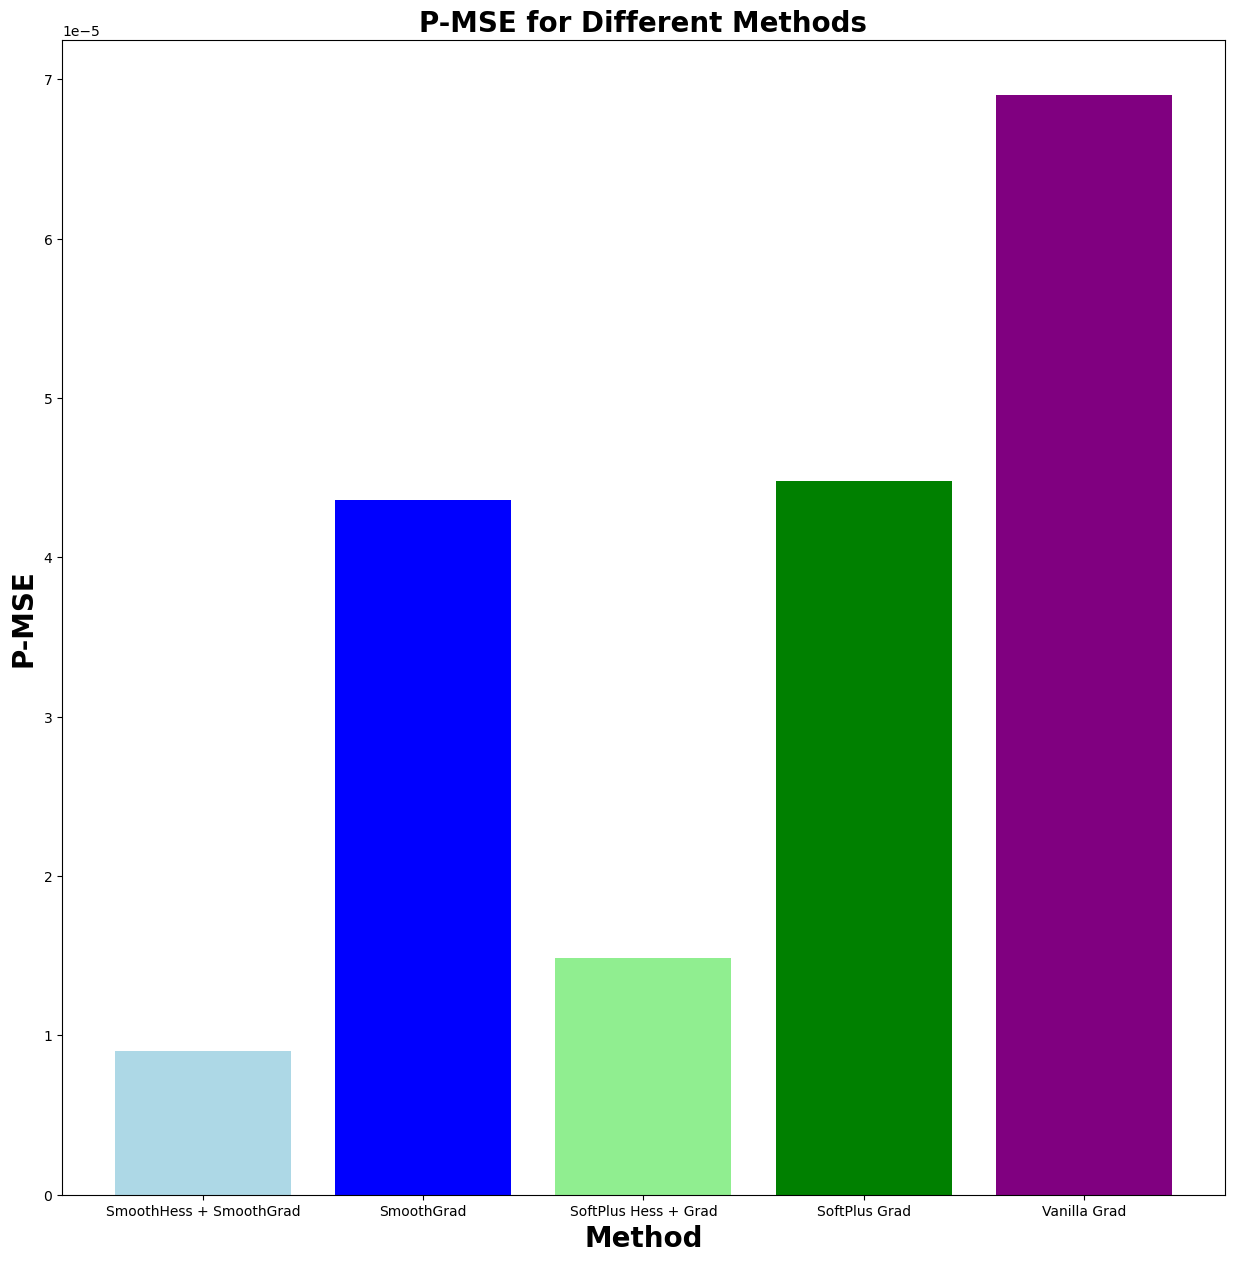

In [22]:
fig = plt.figure(figsize  = (15,15))
methods = ["SmoothHess + SmoothGrad", "SmoothGrad", "SoftPlus Hess + Grad", "SoftPlus Grad", "Vanilla Grad"]
values  = [SmoothHess_PMSE, SmoothGrad_PMSE, SoftPlus_Hess_PMSE, SoftPlus_Grad_PMSE, VanillaGrad_PMSE]
values = [float(val) for val in values]
plt.bar(methods, values, color=['lightblue', 'blue', 'lightgreen', 'green', 'purple'])
plt.title("P-MSE for Different Methods", weight='bold', size = 20)
plt.ylabel("P-MSE", weight='bold', size = 20)
plt.xlabel("Method", weight = "bold", size = 20) 
